In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
from pipeline import Pipeline
from rnn import RNN
from datetime import datetime
import json
import matplotlib.pyplot as plt

### Load datasets

In [3]:
df_train = pd.read_csv("./data/train.csv")
df_valid = pd.read_csv("./data/valid.csv")

#### Process datasets

In [4]:
df_train, train_scale = Pipeline.process(data=df_train, altered=False)
df_valid, valid_scale = Pipeline.process(data=df_valid, altered=False)
df_test = df_valid[len(df_valid)//2:]
df_valid = df_valid[:len(df_valid)//2]

### Parameters
Select features and length of sequences (k)

In [5]:
k = 60
features=[
    'hydro', 
    'micro',
    'thermal',
    'wind', 
    'total',
    'sys_reg', 
    'flow', 
    'time_of_day_sin',
    'time_of_day_cos',
    'time_of_week_sin',
    'time_of_week_cos',
    'time_of_year_sin',
    'time_of_year_cos',
    'time_of_hour_sin',
    'time_of_hour_cos',
    'new_hour',
    'structural_imbalance',
    'prev_day_y',
    'prev_week_y',
    # 'previous_20y']
    'previous_y']
no_features = len(features)

Format data for RNN

In [86]:
x_train, y_train = Pipeline.format_data(df_train, k=k, features=features, noise_prev_no=1)
x_valid, y_valid = Pipeline.format_data(df_valid, k=k, features=features)
x_test, y_test = Pipeline.format_data(df_test, k=k, features=features)

### Build the model

In [80]:
model = RNN(k, no_features)
model.model.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60, 20)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 30)            6120      
                                                                 
 dropout_6 (Dropout)         (None, 60, 30)            0         
                                                                 
 lstm_7 (LSTM)               (None, 20)                4080      
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_6 (Dense)             (None, 100)               2100      
                                                                 
 dense_7 (Dense)             (None, 1)                 1

### Train the model

In [81]:
model.train(
    x_train=x_train,
    y_train=y_train,
    x_valid=x_valid, 
    y_valid=y_valid,
    epochs=10,
    batch_size=128)

Epoch 1/12
1743/1743 [==============================] - 44s 21ms/step - loss: 0.3748 - val_loss: 0.3058
Epoch 2/12
1743/1743 [==============================] - 35s 20ms/step - loss: 0.2282 - val_loss: 0.2672
Epoch 3/12
1743/1743 [==============================] - 36s 20ms/step - loss: 0.2011 - val_loss: 0.2450
Epoch 4/12
1743/1743 [==============================] - 35s 20ms/step - loss: 0.1875 - val_loss: 0.2312
Epoch 5/12
1743/1743 [==============================] - 35s 20ms/step - loss: 0.1742 - val_loss: 0.2086
Epoch 6/12
1743/1743 [==============================] - 36s 20ms/step - loss: 0.1630 - val_loss: 0.1976
Epoch 7/12
1743/1743 [==============================] - 35s 20ms/step - loss: 0.1536 - val_loss: 0.1902
Epoch 8/12
1743/1743 [==============================] - 36s 21ms/step - loss: 0.1470 - val_loss: 0.1820
Epoch 9/12
1743/1743 [==============================] - 36s 20ms/step - loss: 0.1411 - val_loss: 0.1782
Epoch 10/12
1743/1743 [==============================] - 35s 20m

#### Plot training loss

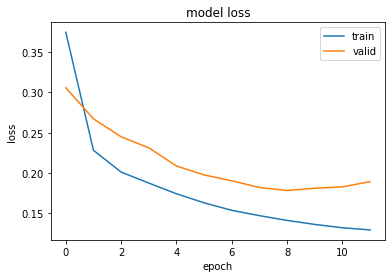

In [82]:
model.plot_train_history()

### Test model
Testing the model on different portions of the test test

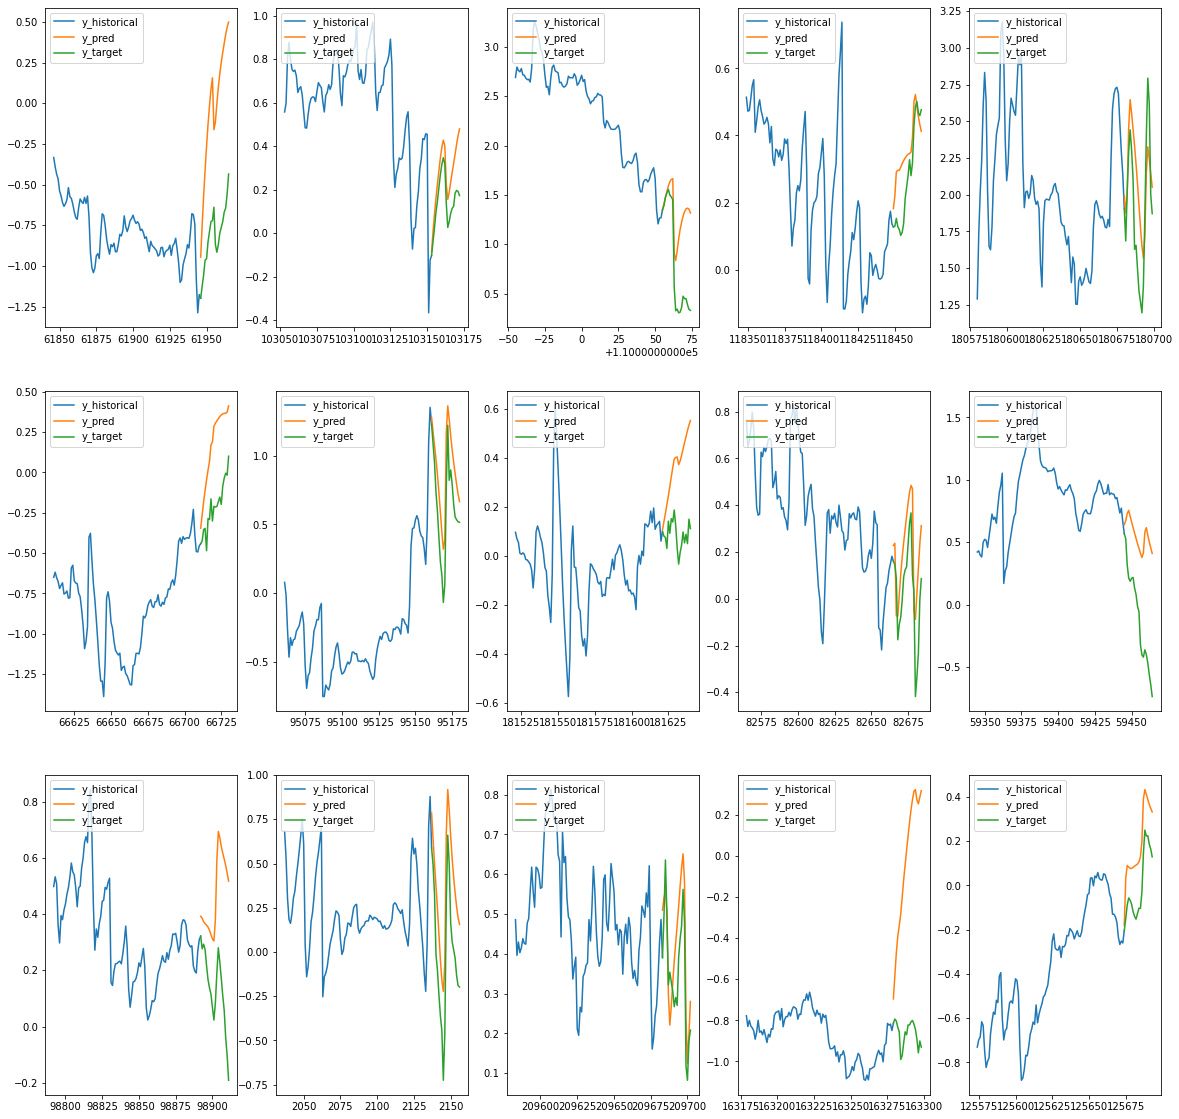

In [87]:
model.forecast_15(x_train, y_train, replace=True, path="./figures/train_set.png")

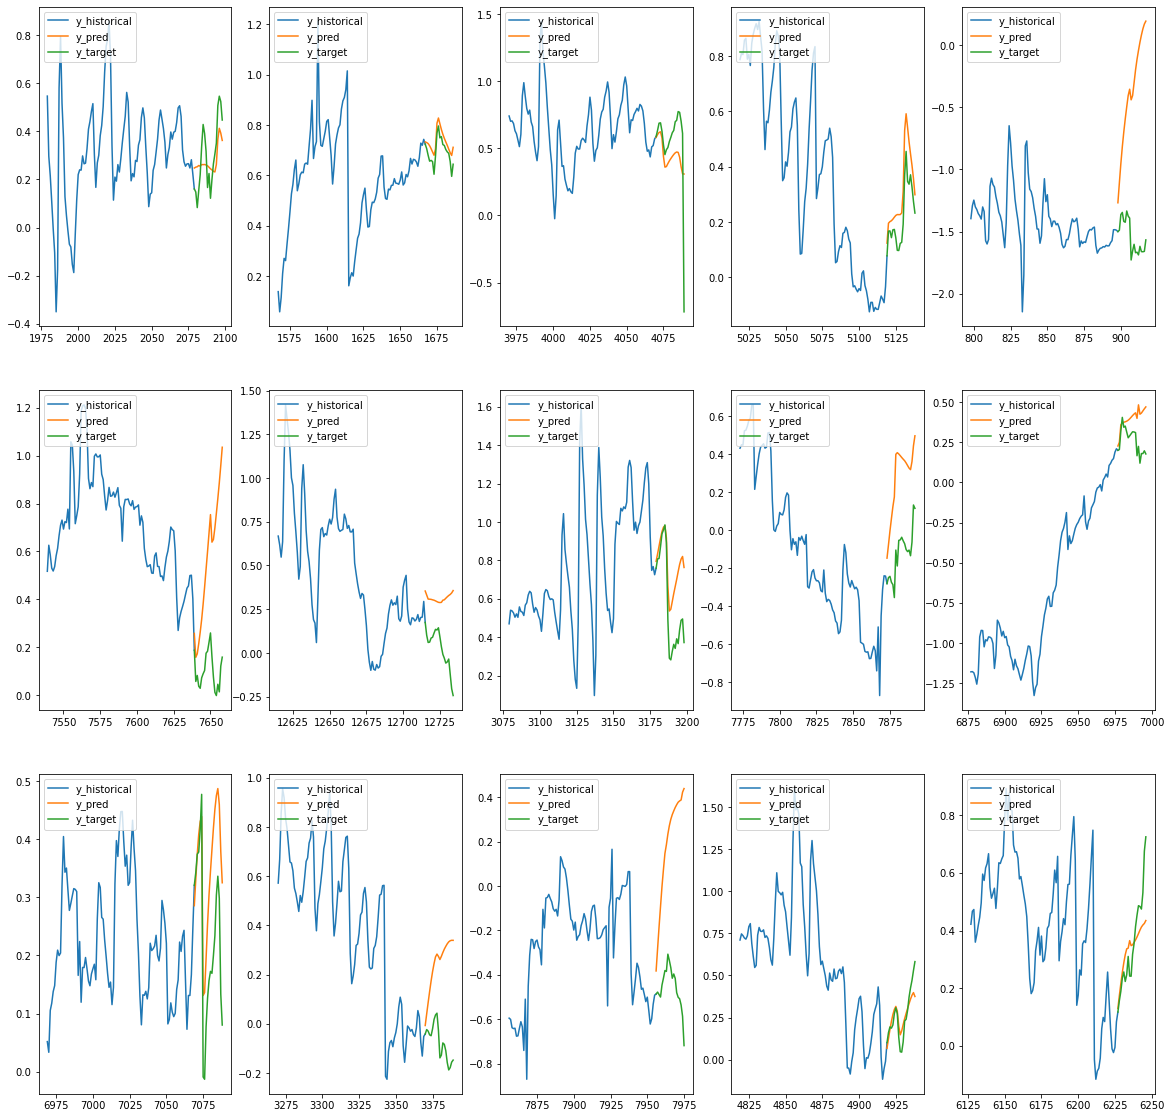

In [83]:
model.forecast_15(x_valid, y_valid,  replace=True, path="./figures/valid_set.png")

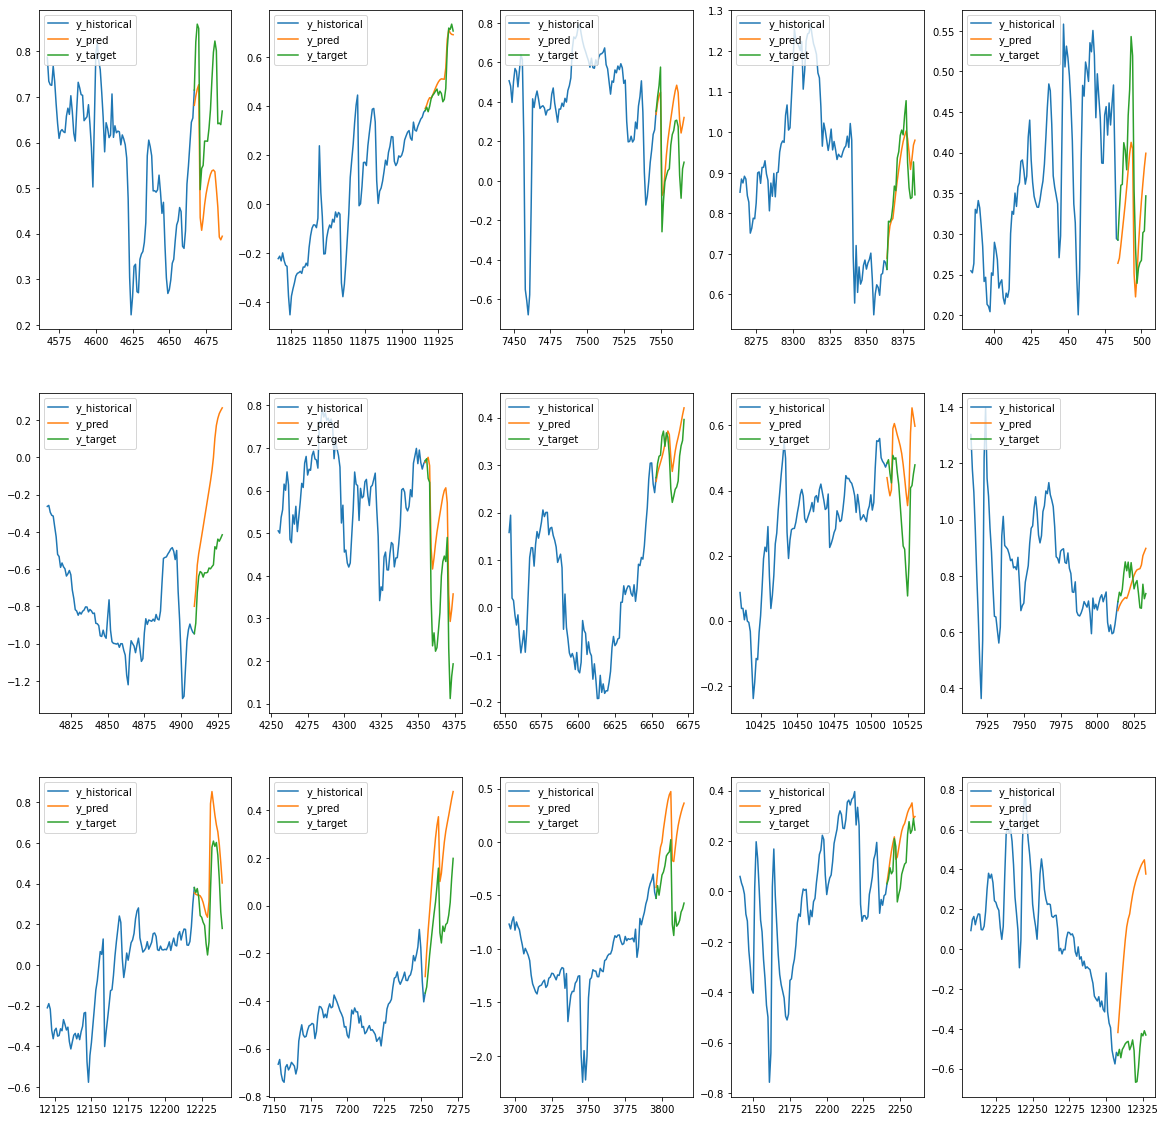

In [84]:
model.forecast_15(x_test, y_test, replace=True, path="./figures/test_set.png")

### Save model

In [89]:
comments = "Added gaussian noise with sigma=0.1"

In [90]:
metadata = {'features': features, 'k':k, 'comments':comments}
timestamp = datetime.now().isoformat()[:19]
timestamp = timestamp.replace(":", "-")
path = f"models/{timestamp}"
model.save_model(path=f"{path}/model")
with open(f"{path}/metadata.json", 'w') as f:
    json.dump(metadata, f)

INFO:tensorflow:Assets written to: models/2022-04-24T13-48-51/model\assets


INFO:tensorflow:Assets written to: models/2022-04-24T13-48-51/model\assets


#### Load model

In [10]:
model.load_model(path=f"./models/2022-04-22T17-36-02/model", new_k=60)

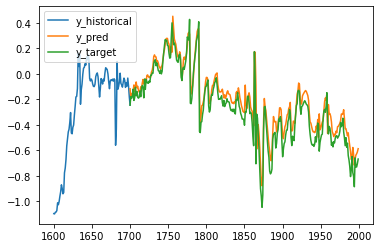

In [93]:
model.forecast_1(x_test, y_test, M=100, n=300, s=1700, replace=False)